In [586]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
# manual feature selection
from collections import defaultdict
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import SparsePCA

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [565]:
X, y = load_data()

## Logistic Regression

In [106]:
df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)

X = pd.DataFrame(PCA().fit_transform(df.drop('dep', axis=1).apply(zscore)))
y = df['dep']

In [93]:
results = pd.DataFrame(logit.gs_clf.cv_results_)

In [94]:
results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_est__C,param_est__class_weight,param_est__max_iter,param_est__penalty,param_est__solver,params,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.003755,0.000933,0.780488,0.805452,1,balanced,100,l1,saga,"{'est__C': 1.0, 'est__class_weight': 'balanced...",...,1.0,0.824808,1.0,0.770202,1.0,0.770202,0.000192,0.000021,0.413916,0.032124
6,0.004150,0.001013,0.780488,0.803220,1.5,balanced,100,l1,saga,"{'est__C': 1.5, 'est__class_weight': 'balanced...",...,1.0,0.824808,1.0,0.770202,1.0,0.770202,0.000974,0.000268,0.413916,0.025788
4,0.003748,0.000943,0.756098,0.796050,0.5,balanced,100,l1,saga,"{'est__C': 0.5, 'est__class_weight': 'balanced...",...,1.0,0.795396,1.0,0.770202,1.0,0.797980,0.000063,0.000023,0.429435,0.026255
7,0.003752,0.000932,0.756098,0.801865,2,balanced,100,l1,saga,"{'est__C': 2.0, 'est__class_weight': 'balanced...",...,1.0,0.824808,1.0,0.770202,1.0,0.770202,0.000058,0.000019,0.429435,0.025518
0,0.002618,0.000916,0.658537,0.713345,0.1,balanced,100,l1,saga,"{'est__C': 0.1, 'est__class_weight': 'balanced...",...,0.0,0.751918,1.0,0.696970,1.0,0.724747,0.000209,0.000048,0.474201,0.031479
3,0.003698,0.000959,0.658537,0.735711,0.25,balanced,100,l1,saga,"{'est__C': 0.25, 'est__class_weight': 'balance...",...,1.0,0.722506,1.0,0.724747,1.0,0.775253,0.000817,0.000230,0.474201,0.025346
1,0.002861,0.000959,0.634146,0.736508,0.15,balanced,100,l1,saga,"{'est__C': 0.15, 'est__class_weight': 'balance...",...,0.0,0.751918,1.0,0.724747,1.0,0.803030,0.000272,0.000531,0.481669,0.033687
2,0.003453,0.000920,0.634146,0.742619,0.2,balanced,100,l1,saga,"{'est__C': 0.2, 'est__class_weight': 'balanced...",...,0.0,0.744246,1.0,0.724747,1.0,0.803030,0.000550,0.000209,0.481669,0.031009


In [103]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

## Quick Model Check
1. PCA -> CV with RF/Logit: 0.824
2. PCA -> CV with Logit: 0.774
3. CV with PCA(n=10)/Logit: 0.774
4. PCA(n=10) -> CV with Logit: 0.774

In [390]:
get_feats_norf = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), index=X.columns)

In [520]:
def crossval(X, y, pipe, get_feats, ite=100, verbose=True):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    for _ in tqdm(range(ite)) if verbose else range(ite):
        for train_idx, test_idx in LeaveOneOut().split(X):

            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = pipe.predict(X.iloc[test_idx])[0]
            proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
            preds.append(pred)
            probs.append(proba)
            fs = get_feats(pipe)
            for f in fs.index:
                if abs(fs[f]) > 0:
                    feats[f].append(fs[f])
    bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])
    return bm, feats


def print_res(bm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])

    print(model)
    print('------------------------')
    print('Recall       : {:1.3f}'.format(rs))
    print('Precision    : {:1.3f}'.format(ps))
    print('Accuracy     : {:1.3f}'.format(acc))
    print('Bal. Accuracy: {:1.3f}'.format(bacc))
    print('ROC AUC.     : {:1.3f}\n'.format(roc))
    
    
def plot_res(feats):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
    axs[0].set_ylabel('Percent of Models w/ Feature')
    fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
    axs[1].set_ylabel('Avg Model Weight')

    sns.despine()

### PCA -> CV: RF(10)/Logit

100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


logit
------------------------
Recall       : 0.870
Precision    : 0.833
Accuracy     : 0.829
Bal. Accuracy: 0.824
ROC AUC.     : 0.790

           mean       std  count
pc_1   0.068690  0.006587      3
pc_10 -0.149404  0.076604     18
pc_2   0.151900  0.027143    410
pc_3  -0.606592  0.049431    410
pc_4   0.234432  0.047769    409
pc_6  -1.398771  0.113600    410


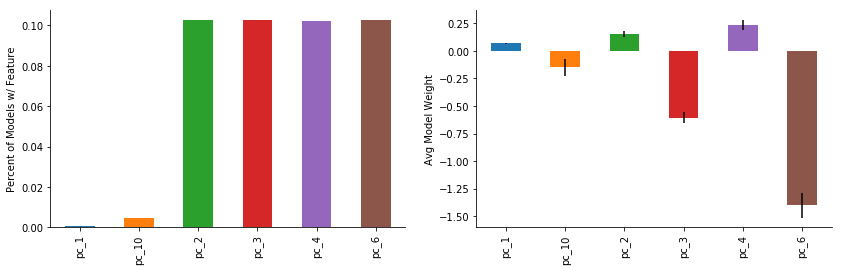

In [421]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
                 
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=X.columns[pipe.steps[-2][1].get_support()])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA/RF(10)/Logit

100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.795

           mean       std  count
pc_1   0.059351  0.000000      1
pc_10  0.703504  0.060290      8
pc_2   0.136246  0.055753    288
pc_3  -0.661105  0.211739    410
pc_4   0.183061  0.117832    312
pc_5  -0.984400  0.419434     12
pc_6  -1.355880  0.195778    349
pc_9  -0.144133  0.054275     11


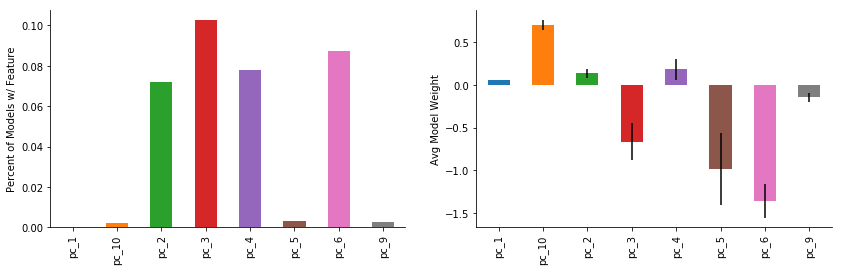

In [498]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=np.array(['pc_' + str(i+1) for i in range(X.shape[1])])[pipe.steps[-2][1].get_support()])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### PCA(10) -> CV: Logit

100%|██████████| 2/2 [00:00<00:00,  7.67it/s]


logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.761

          mean       std  count
pc_1  0.045866  0.014447     82
pc_2  0.111356  0.024737     82
pc_3 -0.574921  0.052454     82
pc_4  0.154549  0.044202     82
pc_6 -0.728814  0.090846     82


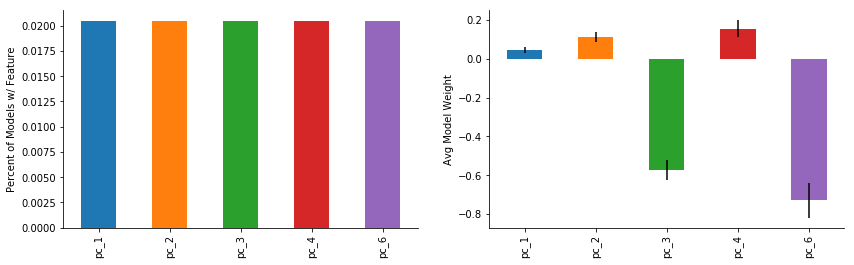

In [425]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe = Pipeline([('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                            max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), index=X.columns)

bm, feats = crossval(X, y, pipe, get_feats, ite=2)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA(10) / Logit

100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


logit
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.725

               mean           std  count
pc_1   6.265955e-02  2.123421e-02    410
pc_10 -9.880119e-02  3.005833e-01    410
pc_11  6.819922e-02  6.453466e-02    410
pc_12 -5.034198e-02  1.005223e-01    410
pc_13  1.109888e-01  8.347907e-02    410
pc_14 -1.009160e-01  1.702078e-01    410
pc_15 -3.985767e-02  1.252703e-01    410
pc_16 -2.552904e-02  6.029560e-02    410
pc_17  1.450059e-01  1.402663e-01    410
pc_18 -1.260625e-01  2.119609e-01    410
pc_19 -1.957092e-02  9.253386e-02    410
pc_2   1.791503e-01  3.839967e-02    410
pc_20 -5.736771e-02  9.035363e-02    410
pc_21 -2.398919e-02  3.643447e-02    410
pc_22 -6.234060e-03  3.865341e-02    410
pc_23 -2.862349e-02  8.820663e-02    410
pc_24 -1.547386e-01  6.500458e-02    410
pc_25 -3.888656e-02  7.810110e-02    410
pc_26 -2.697247e-02  2.052546e-02    410
pc_27  8.875945e-04  2.429914e-02    410
pc

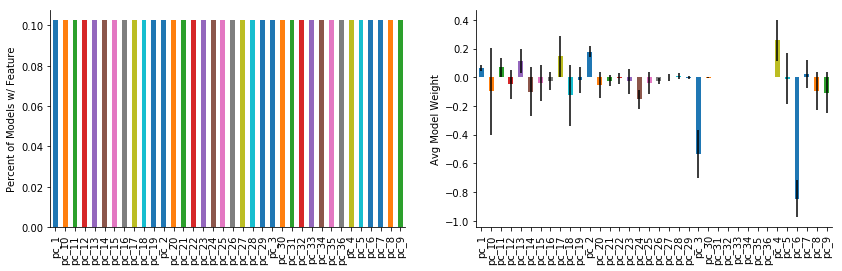

In [502]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.5, penalty='l2', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: PCA(10)/ElasticNet

In [589]:
X, y = load_data()

for ratio in [0, 0.25, 0.5, 0.75, 1]:
    for C in [0.25, 0.5, 1, 1.5]:
#C =1
#ratio = 0.25

        pipe = Pipeline([('pca', PCA(10)),
                         ('clf', LogisticRegression(C=C, penalty='elasticnet', l1_ratio=ratio, 
                                                    class_weight='balanced', solver='saga',
                                                    max_iter=100, tol=1e-6))])

        get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[1][1].coef_), 
                                           index=['pc_' + str(i+1) for i in range(10)])

        bm, feats = crossval(X, y, pipe, get_feats, ite=10, verbose=False)

        model = '\nElasticNet - C: {}, Ratio: {}'.format(C, ratio)

        print_res(bm, model)


#fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
#                              columns=['mean', 'std', 'count'], orient='index').sort_index()
#print(fsrs)

#plot_res(feats)


ElasticNet - C: 0.25, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.742


ElasticNet - C: 0.5, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.739


ElasticNet - C: 1, Ratio: 0
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.739


ElasticNet - C: 1.5, Ratio: 0
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.737


ElasticNet - C: 0.25, Ratio: 0.25
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.744


ElasticNet - C: 0.5, Ratio: 0.25
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.744


ElasticNet - C: 1, Ra

### CV: Logit

100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


logit
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.734

             mean       std  count
theta_0 -0.249192  0.141254    380
theta_2 -0.494704  0.134416    400
theta_3 -0.024723  0.000005     10
theta_5 -0.074228  0.078248    230


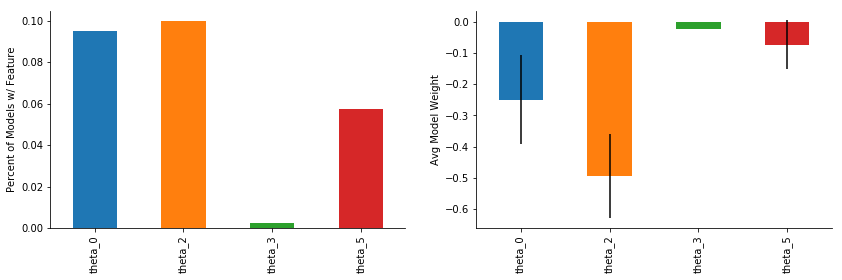

In [548]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticRegression(C=0.25, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### Logit L2

In [ ]:
X, y = load_data()

pipe = Pipeline([('clf', LogisticRegression(C=0.25, penalty='l2', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.732

              mean       std  count
alpha_0  -0.148193  0.021187   4100
alpha_1   0.197100  0.018497   4100
alpha_2  -0.092271  0.025423   4100
alpha_3  -0.019598  0.018401   4100
alpha_4   0.127261  0.021584   4100
alpha_5   0.183548  0.023983   4100
beta_0   -0.025723  0.026295   4100
beta_1    0.229325  0.021878   4100
beta_2    0.072391  0.018779   4100
beta_3   -0.037935  0.027277   4100
beta_4    0.127827  0.016566   4100
beta_5    0.145350  0.017065   4100
delta_0   0.239275  0.019536   4100
delta_1  -0.148510  0.017240   4100
delta_2   0.137320  0.017066   4100
delta_3   0.185124  0.018203   4100
delta_4  -0.057282  0.016002   4100
delta_5   0.007874  0.020046   4100
gammaH_0 -0.107574  0.010934   4100
gammaH_1 -0.041783  0.011724   4100
gammaH_2 -0.117511  0.022900   4100
gammaH_3 -0.037051  0.015283   4100
gammaH_4 -0.041336  0.016918   4100

### ElasticNet w/ anova

100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


logit
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.705

             mean       std  count
delta_0  0.125348  0.102010     50
delta_2 -0.000815  0.000301      9
delta_5 -0.089423  0.065705    380
theta_0 -0.441012  0.111445    410
theta_1  0.233639  0.088127    402
theta_2 -0.678336  0.116755    410
theta_3 -0.157162  0.100015    398
theta_5 -0.373279  0.074940    400


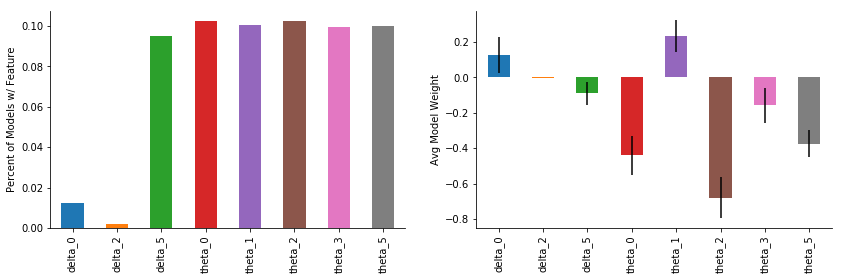

In [551]:
from sklearn.feature_selection import f_classif, SelectKBest

X, y = load_data()

pipe = Pipeline([('f_select', SelectKBest(f_classif, k=10)),
                 ('clf', LogisticRegression(C=1, l1_ratio=0.5, 
                                            penalty='elasticnet', class_weight='balanced', solver='saga',
                                            max_iter=100, tol=1e-6))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[1][1].coef_), 
                                   index=X.columns[pipe.steps[0][1].get_support()])

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### ElasticNet


ElasticNet - C: 1, Ratio: 0.25
------------------------
Recall       : 0.783
Precision    : 0.783
Accuracy     : 0.756
Bal. Accuracy: 0.752
ROC AUC.     : 0.717

              mean       std  count
alpha_0  -0.285253  0.049839    410
alpha_1   0.299824  0.040563    410
alpha_2  -0.117013  0.040927    400
alpha_3  -0.025834  0.015124     52
alpha_4   0.112111  0.051053    410
alpha_5   0.270908  0.060412    410
beta_0   -0.048127  0.044133     60
beta_1    0.408571  0.055031    410
beta_2    0.036938  0.033676    300
beta_3   -0.032097  0.040594    199
beta_4    0.137513  0.040496    410
beta_5    0.191822  0.042513    410
delta_0   0.413391  0.050155    410
delta_1  -0.282746  0.041985    410
delta_2   0.127214  0.037554    400
delta_3   0.276626  0.049868    410
delta_4  -0.035660  0.031753    301
delta_5  -0.009009  0.016501     30
gammaH_0 -0.159768  0.030868    410
gammaH_1 -0.015900  0.022645     51
gammaH_2 -0.196977  0.035044    400
gammaH_3 -0.051296  0.035415     32
gammaH_4 

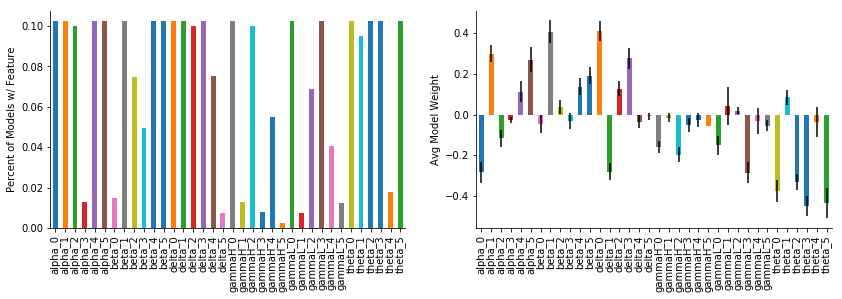

In [552]:
X, y = load_data()

#for ratio in [0, 0.25, 0.5, 0.75, 1]:
#    for C in [0.25, 0.5, 1, 1.5]:
C =1
ratio = 0.25

pipe = Pipeline([('clf', LogisticRegression(C=C, penalty='elasticnet', l1_ratio=ratio, 
                                            class_weight='balanced', solver='saga',
                                            max_iter=100, tol=1e-6))])

get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].coef_), 
                                   index=X.columns)

bm, feats = crossval(X, y, pipe, get_feats, ite=10, verbose=False)

model = '\nElasticNet - C: {}, Ratio: {}'.format(C, ratio)

print_res(bm, model)


fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: RF

100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


logit
------------------------
Recall       : 0.696
Precision    : 0.640
Accuracy     : 0.610
Bal. Accuracy: 0.598
ROC AUC.     : 0.663

              mean       std  count
alpha_0   0.018944  0.005664    410
alpha_1   0.015116  0.004536    410
alpha_2   0.017071  0.005625    410
alpha_3   0.019140  0.005886    410
alpha_4   0.022939  0.007030    410
alpha_5   0.018079  0.005249    410
beta_0    0.016063  0.005109    410
beta_1    0.021854  0.006392    410
beta_2    0.015067  0.004622    410
beta_3    0.016674  0.004901    410
beta_4    0.026336  0.007139    410
beta_5    0.021080  0.006667    410
delta_0   0.023205  0.006903    410
delta_1   0.018852  0.005920    410
delta_2   0.020873  0.006557    410
delta_3   0.026846  0.007412    410
delta_4   0.019212  0.005777    410
delta_5   0.021562  0.007057    410
gammaH_0  0.023589  0.007207    410
gammaH_1  0.018449  0.005321    410
gammaH_2  0.019411  0.005921    410
gammaH_3  0.019695  0.005634    410
gammaH_4  0.020536  0.005783    410

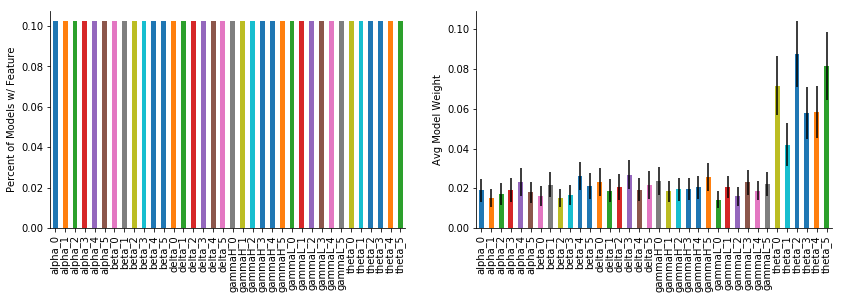

In [465]:
X, y = load_data()

pipe = Pipeline([('clf', RandomForestClassifier(n_estimators=100, max_features=5))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[0][1].feature_importances_), 
                                   index=X.columns)

bm, feats = crossval(X, y, pipe, get_feats, ite=10)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

### CV: SVM (rbf)

In [494]:
X, y = load_data()

pipe = Pipeline([('clf', SVC(C=1, kernel='rbf', class_weight='balanced', probability=True))])
             
get_feats = lambda pipe: pd.Series({'a': 1, 'b': 2})

bm, feats = crossval(X, y, pipe, get_feats, ite=100)

print_res(bm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

#plot_res(feats)

100%|██████████| 100/100 [00:13<00:00,  7.24it/s]

logit
------------------------
Recall       : 0.739
Precision    : 0.630
Accuracy     : 0.610
Bal. Accuracy: 0.592
ROC AUC.     : 0.415

   mean  std  count
a   1.0  0.0   4100
b   2.0  0.0   4100


### CV: SVM (linear)

In [563]:
X, y = load_data()

for C in [0.25, 0.5, 0.75, 1.0, 1.5]:
    
    pipe = Pipeline([('clf', SVC(C=C, kernel='linear', class_weight='balanced', probability=True))])

    get_feats = lambda pipe: pd.Series({'a': 1, 'b': 2})

    bm, feats = crossval(X, y, pipe, get_feats, ite=10)

    print_res(bm, model='Linear SVM ({})'.format(C))

#fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
#                              columns=['mean', 'std', 'count'], orient='index').sort_index()
#print(fsrs)

#plot_res(feats)

  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.25)
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.655



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.5)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.681



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (0.75)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.688



  0%|          | 0/10 [00:00<?, ?it/s]

Linear SVM (1.0)
------------------------
Recall       : 0.739
Precision    : 0.739
Accuracy     : 0.707
Bal. Accuracy: 0.703
ROC AUC.     : 0.699



100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

Linear SVM (1.5)
------------------------
Recall       : 0.696
Precision    : 0.727
Accuracy     : 0.683
Bal. Accuracy: 0.681
ROC AUC.     : 0.606



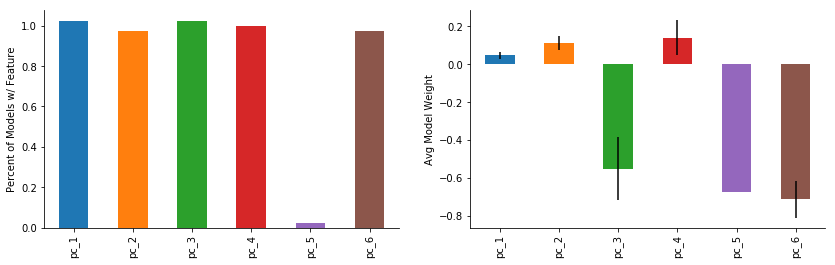

In [394]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
axs[0].set_ylabel('Percent of Models w/ Feature')
fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
axs[1].set_ylabel('Avg Model Weight')

sns.despine()

In [112]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'

for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)), 
                     ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.870
Precision    : 0.833
Accuracy     : 0.829
Bal. Accuracy: 0.824
ROC AUC.     : 0.790



In [158]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('clf', LogisticRegression(C=0.50, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

pipe.steps[0][1].coef_

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.761



array([[ 0.04291451,  0.13707589, -0.51387542,  0.19409212,  0.        ,
        -0.76522394,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [164]:
X, y = load_data()

preds = list()
probs = list()
model = 'logit'

for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('pca', PCA(n_components=10)), 
                     ('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.758



In [170]:
X, y = load_data()
X = pd.DataFrame(PCA(n_components=10).fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.826
Precision    : 0.792
Accuracy     : 0.780
Bal. Accuracy: 0.774
ROC AUC.     : 0.761



1. pca10, np.nan: 0.752
2. pca10, no nan: 0.824
2. pca, np.nan: 0.824
3. pca, no nan: 0.824

In [199]:
X, y = load_data()
X = pd.DataFrame(PCA().fit_transform(X))

preds = list()
probs = list()
model = 'logit'
for train_idx, test_idx in LeaveOneOut().split(X):

    pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=5)), 
                     ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

logit
------------------------
Recall       : 0.870
Precision    : 0.800
Accuracy     : 0.805
Bal. Accuracy: 0.796
ROC AUC.     : 0.771



In [233]:
LeaveOneOut.split?

In [239]:
X, y = load_data(zscore=False)

preds = list()
probs = list()
model = 'logit'
indices = list()

for train_idx, test_idx in LeaveOneOut().split(X):
    indices.append(test_idx)

    pipe = Pipeline([('zscore', StandardScaler()),
                     ('pca', PCA()),
                     ('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)),
                     ('clf', LogisticRegression(C=0.5, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

print(model)
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

pipe.steps[3][1].coef_

logit
------------------------
Recall       : 0.826
Precision    : 0.760
Accuracy     : 0.756
Bal. Accuracy: 0.746
ROC AUC.     : 0.725



array([[ 0.24460432, -0.49228463,  0.        , -0.75391973,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

   est__C  mean_train_score  mean_test_score
0    0.10          0.713345         0.658537
1    0.15          0.736508         0.634146
2    0.20          0.742619         0.634146
3    0.25          0.735711         0.658537
4    0.50          0.796050         0.756098
5    1.00          0.805452         0.780488
6    1.50          0.803220         0.780488
7    2.00          0.801865         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



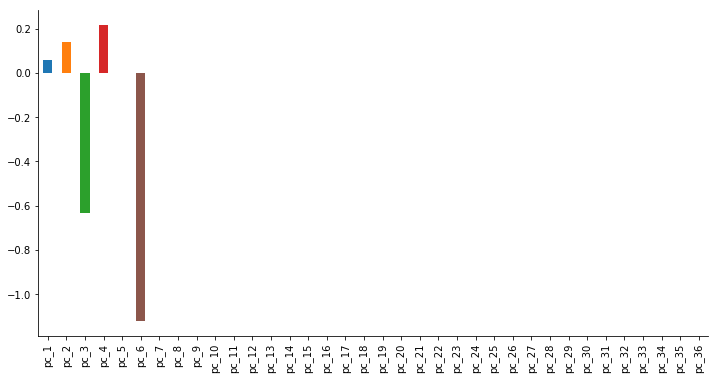

In [92]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

      C  mean_train_score  mean_test_score
0  0.10          0.707255         0.682927
1  0.15          0.738724         0.634146
2  0.20          0.744101         0.634146
3  0.25          0.738664         0.658537
4  0.50          0.796285         0.756098
5  1.00          0.811298         0.780488
6  1.50          0.806914         0.780488
7  2.00          0.804615         0.756098

est
----------
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



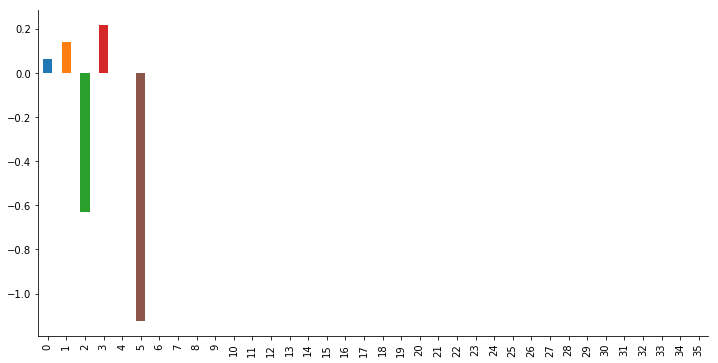

In [59]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=False)
logit.fit(Xpca, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.720859         0.682927

est
----------
LogisticRegression(C=0.15, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



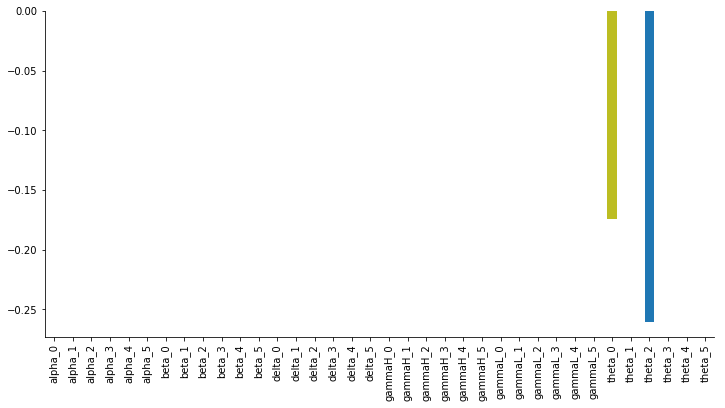

In [57]:
metrics = 'balanced_accuracy'
params = {'C': [0.15],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=False)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.743174         0.634146

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



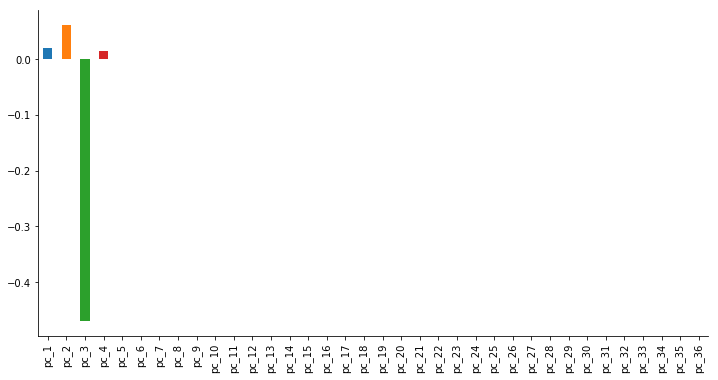

In [76]:
metrics = 'balanced_accuracy'
params = {'C': [0.2],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.736429         0.658537

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



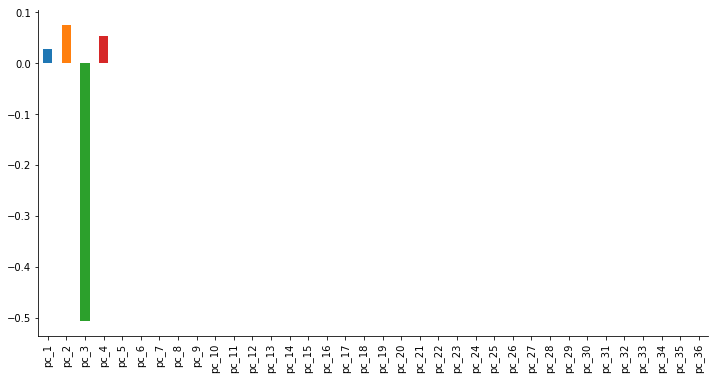

In [77]:
metrics = 'balanced_accuracy'
params = {'C': [0.25],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.799409         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



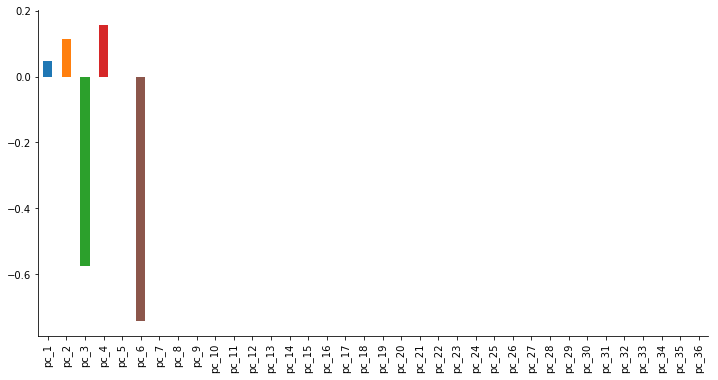

In [78]:
metrics = 'balanced_accuracy'
params = {'C': [0.5],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.819241         0.780488

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



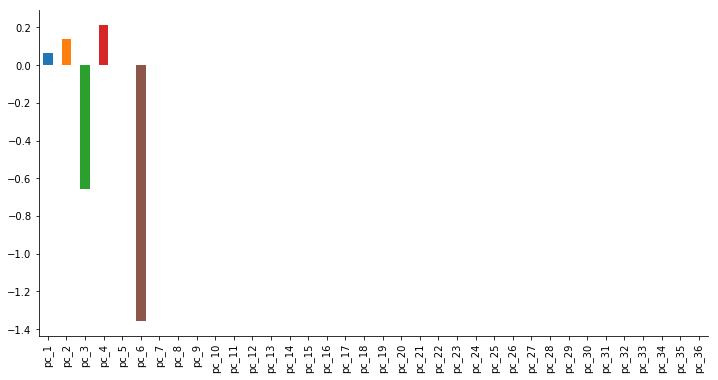

In [79]:
metrics = 'balanced_accuracy'
params = {'C': [1],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.813051         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=1.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



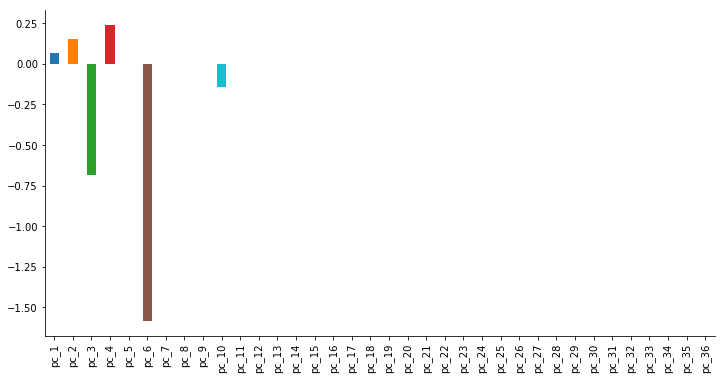

In [80]:
metrics = 'balanced_accuracy'
params = {'C': [1.5],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

   mean_train_score  mean_test_score
0          0.813254         0.756098

pca
----------
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

est
----------
LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)



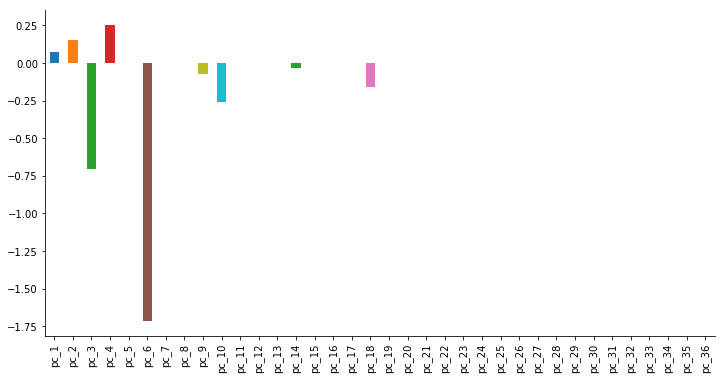

In [81]:
metrics = 'balanced_accuracy'
params = {'C': [2],# np.arange(0.5, 1.01, 0.1),
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [100]}

logit = Logit(params, metrics, pca=True)
logit.fit(X, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

In [82]:
res = pd.DataFrame(
    {'C': [0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0],
     'n_feats': [3, 4, 4, 5, 5, 5, 9],
     'bac': [0.634146, 0.634146, 0.658537, 0.756098, 0.780488, 0.756098, 0.756098]}
)

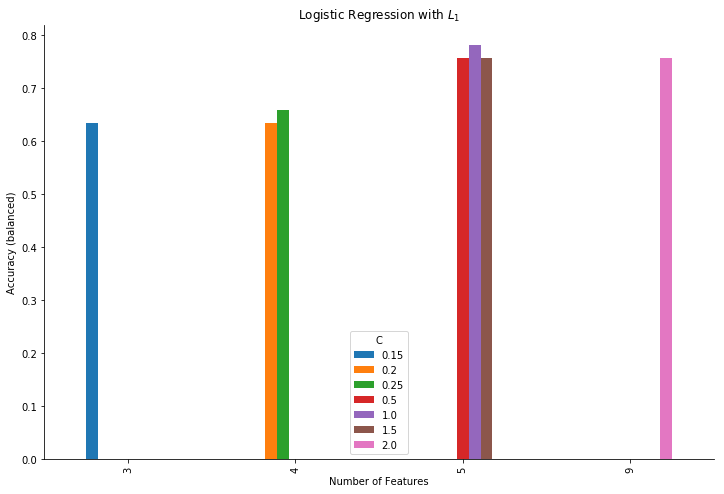

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))

res.pivot(index='n_feats', columns='C', values='bac').plot(kind='bar', ax=ax);

ax.set_xlabel('Number of Features')
ax.set_ylabel('Accuracy (balanced)')
ax.set_title('Logistic Regression with $L_1$')

sns.despine()

## ElasticNet

    alpha  l1_ratio  mean_train_score  mean_test_score
0     0.1      0.00          0.763150         0.682927
1     0.1      0.25          0.723228         0.707317
2     0.1      0.50          0.716646         0.682927
3     0.1      0.75          0.719700         0.658537
4     0.1      1.00          0.706342         0.658537
5     0.3      0.00          0.732968         0.731707
6     0.3      0.25          0.698530         0.658537
7     0.3      0.50          0.685150         0.658537
8     0.3      0.75          0.538506         0.560976
9     0.3      1.00          0.506282         0.536585
10    0.5      0.00          0.729259         0.634146
11    0.5      0.25          0.679652         0.634146
12    0.5      0.50          0.502072         0.560976
13    0.5      0.75          0.500000         0.560976
14    0.5      1.00          0.500000         0.560976
15    1.0      0.00          0.723823         0.634146
16    1.0      0.25          0.503795         0.463415
17    1.0 

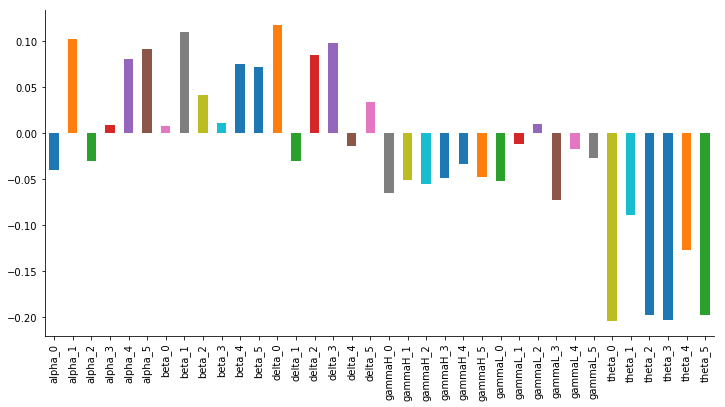

In [19]:
metrics = 'balanced_accuracy'
params = {'alpha':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
          'penalty': ['elasticnet'],
          'loss': ['log'],
          'max_iter': [100]}

sgd = SGDC(params, metrics)
sgd.fit(X, y)
res = sgd.quick_results(df=True)


fig, ax = plt.subplots(figsize=(12, 6))

feats = sgd.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();

In [22]:
res.sort_values('mean_test_score', ascending=False)

,alpha,l1_ratio,mean_train_score,mean_test_score
5,0.3,0.00,0.732968,0.731707
1,0.1,0.25,0.723228,0.707317
0,0.1,0.00,0.763150,0.682927
2,0.1,0.50,0.716646,0.682927
3,0.1,0.75,0.719700,0.658537
4,0.1,1.00,0.706342,0.658537
6,0.3,0.25,0.698530,0.658537
7,0.3,0.50,0.685150,0.658537
10,0.5,0.00,0.729259,0.634146
11,0.5,0.25,0.679652,0.634146


   alpha  mean_train_score  mean_test_score
0    0.1          0.713054         0.658537
1    0.3          0.681261         0.609756
2    0.5          0.501395         0.560976
3    1.0          0.500000         0.487805
4    1.5          0.500000         0.512195
5    2.0          0.500000         0.487805

est
----------
SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.5,
              learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



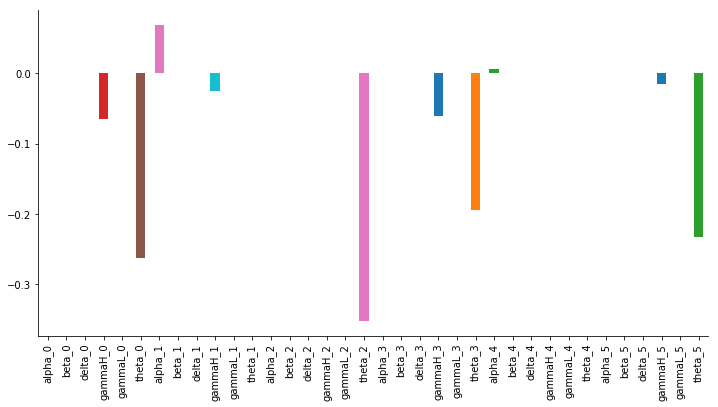

In [36]:
params = {'alpha':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'l1_ratio': [0.5],
          'penalty': ['elasticnet'],
          'loss': ['log'],
          'max_iter': [100]}

sgd = SGDC(params, metrics)
sgd.fit(X, y)
res = sgd.quick_results(df=True)


fig, ax = plt.subplots(figsize=(12, 6))

feats = sgd.feat_importances()
sorted_idx = sorted(feats.index, key=lambda i: [i[-1], i[:-1]])
feats[sorted_idx].plot(kind='bar', ax=ax)

sns.despine();

## PCA top 10

     C  mean_train_score  mean_test_score
0  0.1          0.707295         0.682927
1  0.3          0.766579         0.658537
2  0.5          0.798437         0.780488
3  1.0          0.826442         0.756098
4  1.5          0.817395         0.756098
5  2.0          0.812454         0.756098

est
----------
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)



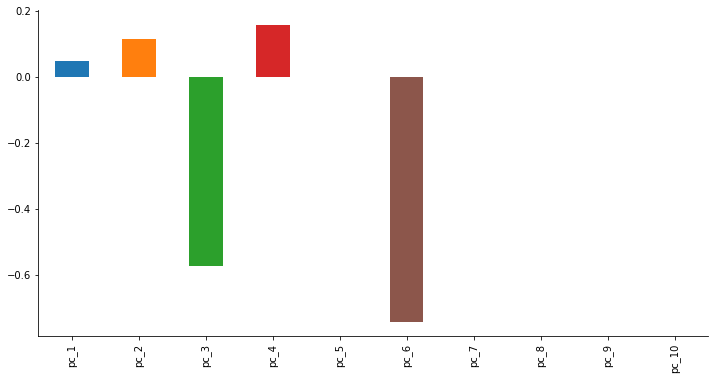

In [24]:
metrics = 'balanced_accuracy'
params = {'C':[0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
          'class_weight': ['balanced'],
          'penalty': ['l1'],
          'solver': ['saga'],
          'max_iter': [200]}
n_components = 10
Xpca = pd.DataFrame(PCA(n_components).fit_transform(X), 
                    columns=['pc_' + str(i) for i in range(1, n_components+1)])
logit = Logit(params, metrics, pca=False)
logit.fit(Xpca, y)
logit.quick_results()

fig, ax = plt.subplots(figsize=(12, 6))

feats = logit.feat_importances()

feats.plot(kind='bar', ax=ax)

sns.despine();